In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV , train_test_split , cross_val_score
from sklearn.metrics import classification_report , confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('Pima Indians Diabetes.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


columns like ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] can not have the value 0 it's probably nan that filled as zero

In [7]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

# dealing with outliers

In [8]:
df.corr()['Outcome'].abs().sort_values(ascending = False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

<AxesSubplot:xlabel='Insulin', ylabel='Outcome'>

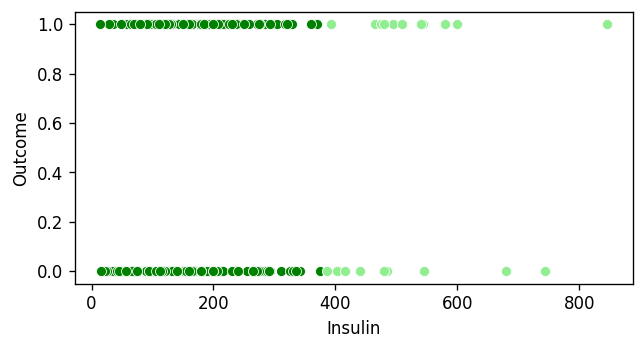

In [9]:
plt.figure(figsize = (6,3),dpi = 120)
sns.scatterplot(data = df , x= 'Insulin' , y = 'Outcome' , color = 'green')
sns.scatterplot(data = df[df['Insulin']>380] ,x = 'Insulin' ,y = 'Outcome' , color = 'lightgreen')

In [10]:
df.corr()['Outcome'].abs().sort_values(ascending = False)[:7].index

Index(['Outcome', 'Glucose', 'BMI', 'Insulin', 'SkinThickness', 'Age',
       'Pregnancies'],
      dtype='object')

In [11]:
df['Insulin'] = df['Insulin'].apply(lambda x : round(df[df['Insulin']<350]['Insulin'].mean(),0) if x>380 else x)

# dealing with missing values

In [12]:
def missing_per():
    miss_df = pd.DataFrame(df.isnull().sum(),columns = ['missing values'])
    miss_df = miss_df[miss_df['missing values']!=0]
    miss_df['percent missing values'] = round(miss_df['missing values']/df.shape[0] * 100,2)
    miss_df = miss_df.sort_values('percent missing values',ascending = False)
    plt.figure(figsize = (12,5) , dpi = 150)
    sns.barplot(x= miss_df.index , y = miss_df['percent missing values'] , palette = 'rocket')
    plt.xticks(rotation = 60);

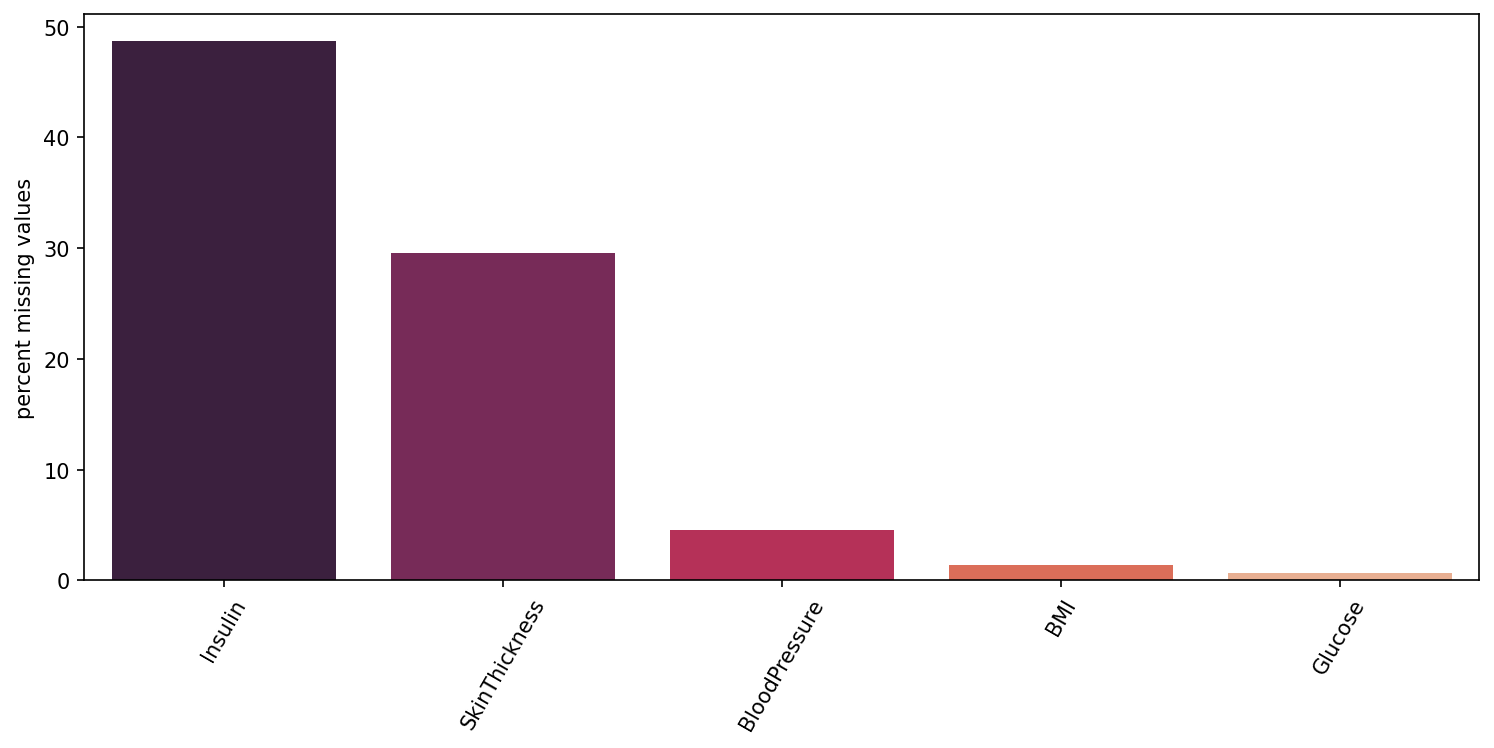

In [13]:
missing_per()

# Filling the missing values based on each columns' median per class

In [14]:
miss_df = pd.DataFrame(df.isnull().sum(),columns = ['missing values'])
miss_df = miss_df[miss_df['missing values']!=0]
miss_df['percent missing values'] = round(miss_df['missing values']/df.shape[0] * 100,2)
miss_df = miss_df.sort_values('percent missing values',ascending = False)

In [15]:
for col in miss_df.index.tolist():
    df[col] = df.groupby('Outcome')[col].transform(lambda value : value.fillna(value.median()))

# checking multicolaniarity

In [16]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [17]:
#these columns are too correlated with each other
considered_features = ['Age' , 'Pregnancies' , 'Insulin' , 'Glucose' , 'SkinThickness' , 'BMI']
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_13932/3029803517.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
5,BMI,1.537717
0,Age,1.519361
4,SkinThickness,1.512394
1,Pregnancies,1.425296
3,Glucose,1.383508
2,Insulin,1.316558


# standard scaler

In [18]:
x = df.drop('Outcome',axis = 1)

In [19]:
y= df['Outcome']

In [20]:
expln_variance = []
for i in range(1,9):
    pca = PCA(n_components = i)
    pca.fit(x)
    expln_variance.append(sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Explained variance')

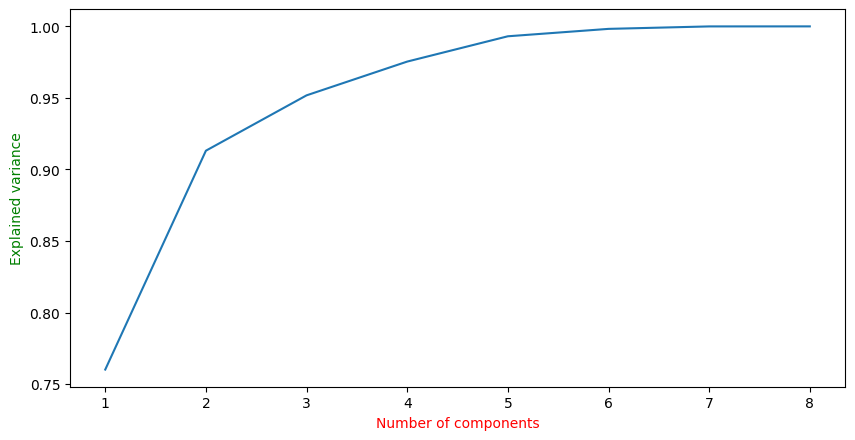

In [21]:
plt.figure(figsize = (10,5) , dpi= 100)
plt.plot(range(1,9) , expln_variance)
plt.xlabel('Number of components' , color = 'red')
plt.ylabel('Explained variance' , color = 'green')

In [22]:
pca_x = PCA(n_components=5).fit_transform(x)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(pca_x,y,test_size = 0.3,random_state=101)

In [24]:
scaler = StandardScaler()

In [25]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# MLP

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=100 , 
                   activation = 'relu',
                   solver = 'adam',
                   learning_rate='constant',
                   random_state = 42).fit(x_train,y_train)

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
print(classification_report(y_test , mlp.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       150
           1       0.83      0.83      0.83        81

    accuracy                           0.88       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.88      0.88      0.88       231



In [28]:
score_mlp = []
for i in [50,100,150,200]:
    for j in ['identity', 'logistic', 'tanh', 'relu']:
        for k in ['lbfgs','sgd','adam']:
            for l in ['constant', 'invscaling', 'invscaling']:
                mlp = MLPClassifier(hidden_layer_sizes = i , activation=j , solver=k,learning_rate=l , random_state=42)
                score_mlp.append([i,j,k,l, np.mean(cross_val_score(mlp, x_train, y_train,scoring='recall',cv=5))])

score_mlp = pd.DataFrame(score_mlp)
score_mlp = score_mlp.sort_values(by=4, ascending=False)
#score_mlp.columns=['n_neighbors','weights','algorithm','accuracy']


C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

In [29]:
score_mlp

,0,1,2,3,4
19,50,tanh,lbfgs,invscaling,0.802560
20,50,tanh,lbfgs,invscaling,0.802560
18,50,tanh,lbfgs,constant,0.802560
69,100,relu,adam,constant,0.792034
71,100,relu,adam,invscaling,0.792034
...,...,...,...,...,...
12,50,logistic,sgd,constant,0.000000
13,50,logistic,sgd,invscaling,0.000000
85,150,logistic,sgd,invscaling,0.000000
84,150,logistic,sgd,constant,0.000000


In [30]:
mlp = MLPClassifier(hidden_layer_sizes = 50 , activation='tanh' , solver='lbfgs',learning_rate='invscaling', random_state=42).fit(x_train, y_train)

In [31]:
print(classification_report(y_test , mlp.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       150
           1       0.75      0.80      0.77        81

    accuracy                           0.84       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.84      0.84      0.84       231



# voting  classfication

In [47]:
lr = LogisticRegression(penalty = 'l2',C=1 , solver = 'newton-cg').fit(x_train , y_train)

In [48]:
print(classification_report(y_test , lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       150
           1       0.74      0.59      0.66        81

    accuracy                           0.78       231
   macro avg       0.77      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231



In [53]:
tree = DecisionTreeClassifier(criterion='gini',splitter = 'best').fit(x_train,y_train)

In [54]:
print(classification_report(y_test , tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       150
           1       0.75      0.74      0.75        81

    accuracy                           0.82       231
   macro avg       0.81      0.80      0.80       231
weighted avg       0.82      0.82      0.82       231



In [55]:
nb = GaussianNB()

In [56]:
model = VotingClassifier(estimators=[('lr', lr), ('dt', tree), ('gnb', nb)],voting='hard')

In [57]:
model.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, solver='newton-cg')),
                             ('dt', DecisionTreeClassifier()),
                             ('gnb', GaussianNB())])

In [59]:
print(classification_report(y_test , model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       150
           1       0.75      0.59      0.66        81

    accuracy                           0.79       231
   macro avg       0.78      0.74      0.75       231
weighted avg       0.78      0.79      0.78       231



In [60]:
model1 = VotingClassifier(estimators=[('lr', lr), ('dt', tree), ('gnb', nb)],voting='soft' , weights=[2,2,1]).fit(x_train, y_train)

In [61]:
print(classification_report(y_test , model1.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       150
           1       0.78      0.80      0.79        81

    accuracy                           0.85       231
   macro avg       0.84      0.84      0.84       231
weighted avg       0.85      0.85      0.85       231



# without hyper tuning and balancing and no impution and and use plot pca

In [62]:
nb = GaussianNB()

In [63]:
nb.fit(x_train , y_train)

GaussianNB()

In [64]:
print(classification_report(y_test , nb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       150
           1       0.70      0.53      0.61        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.75      0.76      0.75       231



In [65]:
confusion_matrix(y_test , nb.predict(x_test))

array([[132,  18],
       [ 38,  43]], dtype=int64)

# grid , plot pca , without balancing , no impution

In [66]:
param_grid_NB = {
    'var_smoothing': np.logspace(0,-9, num=100)}

In [67]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [68]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       150
           1       0.73      0.51      0.60        81

    accuracy                           0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.76      0.76      0.75       231



# grid , balance , plot pca no impution : *Best Result*

In [69]:
x = df.drop('Outcome',axis = 1)
y = df['Outcome']

In [70]:
oversample = SMOTE(k_neighbors=4 , random_state = 101)  # in aadad o alaki grftim
x, y = oversample.fit_resample(x, y)

In [71]:
pca_x = PCA(n_components = 5).fit_transform(x)

In [72]:
x_train,x_test,y_train,y_test = train_test_split(pca_x,y,test_size = 0.3,random_state=101)

In [73]:
x_train =scaler.fit_transform(x_train) 
x_test = scaler.fit_transform(x_test)

In [74]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [75]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       153
           1       0.80      0.86      0.83       147

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



# grid , pca , without balance and no impution

In [76]:
x = df.drop('Outcome',axis = 1)
y = df['Outcome']

In [77]:
scaled_x = StandardScaler().fit_transform(x)

In [78]:
pca = PCA().fit(scaled_x)

In [79]:
loading = pca.components_

In [84]:
num_pc = pca.n_features_

In [85]:
pc_list = ["PC"+str(i) for i in range(1, num_pc+1)]

In [253]:
loadings_df = pd.DataFrame(loading , index = pc_list).T
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.290968,-0.559916,-0.060120,0.166700,-0.397932,-0.266279,-0.512117,0.280908
1,0.422694,0.056519,0.442347,-0.265340,0.170003,0.609687,-0.387091,0.040018
2,0.361034,-0.157773,-0.354809,-0.042723,0.778414,-0.200363,0.048401,0.261976
3,0.395709,0.328548,-0.384019,0.044187,-0.396426,0.290322,0.343343,0.476154
4,0.369128,0.145486,0.514389,-0.362207,-0.119525,-0.577561,0.305832,0.073430
5,0.398395,0.421560,-0.354205,0.015795,-0.087370,-0.206535,-0.345415,-0.606840
6,0.147352,0.261222,0.369996,0.858630,0.153172,-0.070050,-0.000793,0.086829
7,0.364758,-0.532304,0.019992,0.171290,-0.065471,0.227608,0.504801,-0.492898


In [254]:
loadings_df['variable'] = df.columns[:-1]

In [255]:
loadings_df = loadings_df.set_index('variable')

In [256]:
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
variable,,,,,,,,
Pregnancies,0.290968,-0.559916,-0.060120,0.166700,-0.397932,-0.266279,-0.512117,0.280908
Glucose,0.422694,0.056519,0.442347,-0.265340,0.170003,0.609687,-0.387091,0.040018
BloodPressure,0.361034,-0.157773,-0.354809,-0.042723,0.778414,-0.200363,0.048401,0.261976
SkinThickness,0.395709,0.328548,-0.384019,0.044187,-0.396426,0.290322,0.343343,0.476154
Insulin,0.369128,0.145486,0.514389,-0.362207,-0.119525,-0.577561,0.305832,0.073430
BMI,0.398395,0.421560,-0.354205,0.015795,-0.087370,-0.206535,-0.345415,-0.606840
DiabetesPedigreeFunction,0.147352,0.261222,0.369996,0.858630,0.153172,-0.070050,-0.000793,0.086829
Age,0.364758,-0.532304,0.019992,0.171290,-0.065471,0.227608,0.504801,-0.492898


In [257]:
mask = np.triu(np.ones_like(loadings_df ,dtype = bool))

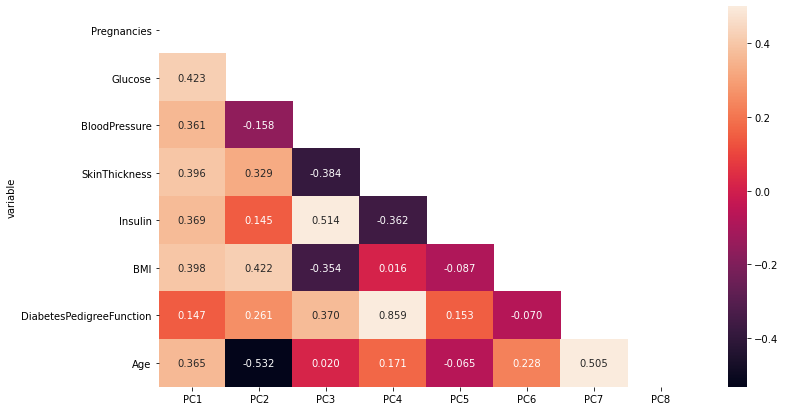

In [258]:
plt.figure(figsize = (12,7))
sns.heatmap(loadings_df , annot = True , vmax = 0.5 , mask = mask , fmt = '.3f');

In [259]:
pca_scores = PCA().fit_transform(scaled_x)

In [260]:
df_new = pd.DataFrame(pca_scores, columns = pc_list)
df_new

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,1.637668,-0.581028,0.489403,0.382862,-0.490358,0.535025,0.372565,-0.207026
1,-1.578809,0.067311,-0.362824,0.005948,-0.190694,0.013130,0.928205,0.115146
2,0.788672,-0.635923,1.876769,0.020844,-0.660172,1.063521,-0.780380,1.347551
3,-2.151747,0.230559,-0.423188,-0.623329,0.068982,-0.215123,0.094726,0.026500
4,0.859053,3.510032,2.832115,4.292092,-1.187002,0.219366,0.156353,-1.087804
...,...,...,...,...,...,...,...,...
763,2.353534,-1.831488,-1.166287,-0.114958,-1.875880,-0.252040,1.611086,0.277870
764,-0.486447,0.641445,-0.418477,-0.354488,0.131933,0.161912,-0.439782,-0.508686
765,-0.860404,-0.869300,0.159736,-0.512514,0.132778,0.039641,-0.316531,0.366406
766,-0.011153,-0.042952,0.605157,-0.418124,-0.728009,0.696381,1.296391,-0.711860


In [261]:
df_new['Outcome']=y

In [262]:
lamda_values= pca.explained_variance_ratio_

In [263]:
def select():
    pov=0.9
    sum_of_lamdas=0
    for i in range(len(x.columns)):
        sum_of_lamdas=sum_of_lamdas+lamda_values[i]
        if sum_of_lamdas>=pov:
            return(i+1)
print(select())

7


In [264]:
de_label=[]
for i in range(len(x.columns)-select()):
    current_pc = "PC" + str(len(x.columns)-i)
    de_label.append(current_pc)


In [265]:
df_new_f = df_new.drop(de_label, axis=1)

In [266]:
df_new_f

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Outcome
0,1.637668,-0.581028,0.489403,0.382862,-0.490358,0.535025,0.372565,1
1,-1.578809,0.067311,-0.362824,0.005948,-0.190694,0.013130,0.928205,0
2,0.788672,-0.635923,1.876769,0.020844,-0.660172,1.063521,-0.780380,1
3,-2.151747,0.230559,-0.423188,-0.623329,0.068982,-0.215123,0.094726,0
4,0.859053,3.510032,2.832115,4.292092,-1.187002,0.219366,0.156353,1
...,...,...,...,...,...,...,...,...
763,2.353534,-1.831488,-1.166287,-0.114958,-1.875880,-0.252040,1.611086,0
764,-0.486447,0.641445,-0.418477,-0.354488,0.131933,0.161912,-0.439782,0
765,-0.860404,-0.869300,0.159736,-0.512514,0.132778,0.039641,-0.316531,0
766,-0.011153,-0.042952,0.605157,-0.418124,-0.728009,0.696381,1.296391,1


In [267]:
x = df_new_f.drop('Outcome',axis =1)
y = df_new_f['Outcome']

In [268]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [269]:
x_train =scaler.fit_transform(x_train) 
x_test = scaler.fit_transform(x_test)

In [270]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [271]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       150
           1       0.72      0.58      0.64        81

    accuracy                           0.77       231
   macro avg       0.76      0.73      0.74       231
weighted avg       0.77      0.77      0.77       231



# grid , pca , balance no impution

In [272]:
x = df_new_f.drop('Outcome',axis =1)
y = df_new_f['Outcome']

In [273]:
oversample = SMOTE(k_neighbors=4, random_state = 101)  # in aadad o alaki grftim
x, y = oversample.fit_resample(x, y)

In [274]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=101)

In [275]:
x_train =scaler.fit_transform(x_train) 
x_test = scaler.fit_transform(x_test)

In [276]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [277]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       153
           1       0.78      0.77      0.77       147

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



# using iterative impution for filling missing values

In [278]:
df = pd.read_csv('Pima Indians Diabetes.csv')

In [279]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

In [280]:
df['Insulin'] = df['Insulin'].apply(lambda x : round(df[df['Insulin']<350]['Insulin'].mean(),0) if x>380 else x)

In [281]:
df_imp = IterativeImputer(random_state=0).fit_transform(df)

In [282]:
df = pd.DataFrame(df_imp , columns = df.columns)

# grid , plot pca no balance , with impution

In [283]:
x = df.drop('Outcome' , axis = 1)
y = df['Outcome']

In [284]:
expln_variance = []
for i in range(1,9):
    pca = PCA(n_components = i)
    pca.fit(x)
    expln_variance.append(sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Explained variance')

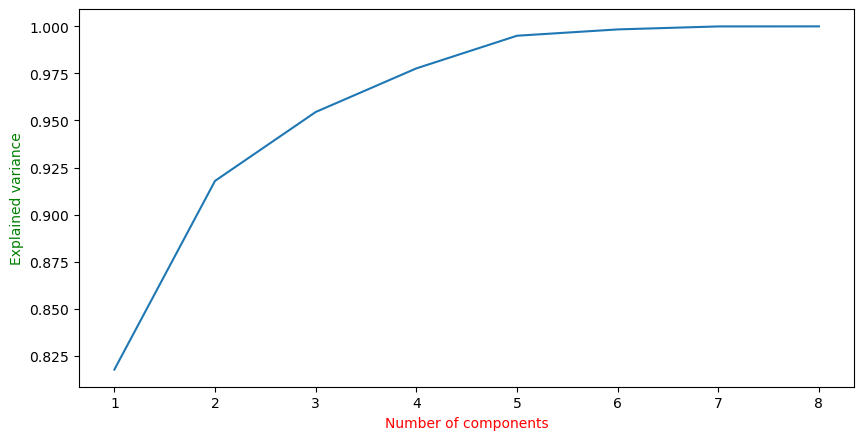

In [285]:
plt.figure(figsize = (10,5) , dpi= 100)
plt.plot(range(1,9) , expln_variance)
plt.xlabel('Number of components' , color = 'red')
plt.ylabel('Explained variance' , color = 'green')

In [286]:
pca_x = PCA(n_components=5).fit_transform(x)

In [287]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=101)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [288]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [289]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       150
         1.0       0.65      0.67      0.66        81

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



# grid , pca plot , balanced , with impution

In [290]:
x = df.drop('Outcome',axis = 1)
y = df['Outcome']
oversample = SMOTE(k_neighbors=4 , random_state = 101)  # in aadad o alaki grftim
x, y = oversample.fit_resample(x, y)
pca_x = PCA(n_components = 5).fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(pca_x,y,test_size = 0.3,random_state=101)
x_train =scaler.fit_transform(x_train) 
x_test = scaler.fit_transform(x_test)
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [291]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       153
         1.0       0.73      0.75      0.74       147

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



# grid , pca , no balance with impution

In [292]:
x = df.drop('Outcome',axis = 1)
y = df['Outcome']
scaled_x = StandardScaler().fit_transform(x)
pca = PCA().fit(scaled_x)
loading = pca.components_
pc_list = ["PC"+str(i) for i in range(1, num_pc+1)]
loadings_df = pd.DataFrame(loading , index = pc_list).T
loadings_df['variable'] = df.columns[:-1]
loadings_df = loadings_df.set_index('variable')
pca_scores = PCA().fit_transform(scaled_x)
df_new = pd.DataFrame(pca_scores, columns = pc_list)
df_new['Outcome']=y
lamda_values= pca.explained_variance_ratio_
def select():
    pov=0.9
    sum_of_lamdas=0
    for i in range(len(x.columns)):
        sum_of_lamdas=sum_of_lamdas+lamda_values[i]
        if sum_of_lamdas>=pov:
            return(i+1)
print(select())
de_label=[]
for i in range(len(x.columns)-select()):
    current_pc = "PC" + str(len(x.columns)-i)
    de_label.append(current_pc)
df_new_f = df_new.drop(de_label, axis=1)
x = df_new_f.drop('Outcome',axis =1)
y = df_new_f['Outcome']

6


In [293]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=101)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [294]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [295]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       150
         1.0       0.69      0.59      0.64        81

    accuracy                           0.76       231
   macro avg       0.74      0.72      0.73       231
weighted avg       0.76      0.76      0.76       231



# grid , pca ,balanced with impution

In [296]:
x = df.drop('Outcome',axis = 1)
y = df['Outcome']

In [297]:
oversample = SMOTE(k_neighbors=4, random_state = 101)  # in aadad o alaki grftim
x, y = oversample.fit_resample(x, y)

In [298]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=101)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [299]:
grid_NB = GridSearchCV(GaussianNB() , param_grid_NB ,scoring = 'accuracy' ,cv = 5 )
grid_NB.fit(x_train , y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [300]:
print(classification_report(y_test , grid_NB.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       153
         1.0       0.72      0.75      0.74       147

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300

